## A notebook for the pre-processing of the game data: 

- make one single csv file (and one for each participant): concatenate the csvs for autumn, winter, and summer data
- calculate the accuracy for each participant a) for the whole game and b) for each individual scene
- export the accuracies in a new csv file / table (to be used for statistical analysis)

In [1]:

import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


### Preprocess data so that it can be handeled better using pandas 


In [2]:
# Define the folder paths
folders = [
    "ERPLogsAutumn", 
    "ERPLogsSummer",
    "ERPLogsWinter"
]

# Loop through each folder
for folder in folders:
    cleaned_folder = os.path.join('game_prep')
    os.makedirs(cleaned_folder, exist_ok=True)

    for filename in os.listdir(folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder, filename)

            # Read the file without headers
            df = pd.read_csv(file_path, header=None)

            # Use the first row as header & get rid of empty spaces 
            df.columns = df.iloc[0].astype(str).str.strip()
            df = df[1:]  # Drop the header row

            # Save cleaned version
            cleaned_path = os.path.join(cleaned_folder, filename)
            df.to_csv(cleaned_path, index=False)

print("All files cleaned with proper headers and saved to 'game_prep' folder.")


All files cleaned with proper headers and saved to 'game_prep' folder.


### Concatenate all csv files

In [3]:
# read path with all csvs
all_path = "game_prep/"

# Concatenate all cleaned CSVs (fix header whitespace here again)
all_files_list = os.listdir(all_path)
all_dfs = []

for f in all_files_list:
    df = pd.read_csv(os.path.join(all_path, f), sep=';')  
    df.columns = df.columns.str.strip()  # Strip whitespace again
    all_dfs.append(df)

df_concat = pd.concat(all_dfs, ignore_index=True)

print(df_concat.head())

df_concat.to_csv('game_all_merged.csv', index=False)

print("Merged CSV saved as 'game_all_merged.csv'")

   Timestamp                                       ObjectName      ID  \
0     250.56  ERPTagsA1 ERPFlashTag2D (4) ERPFlashTagFeedback  28CO38   
1     254.52  ERPTagsA2 ERPFlashTag2D (4) ERPFlashTagFeedback  28CO38   
2     256.83  ERPTagsA2 ERPFlashTag2D (2) ERPFlashTagFeedback  28CO38   
3     261.48  ERPTagsA3 ERPFlashTag2D (4) ERPFlashTagFeedback  28CO38   
4     262.61  ERPTagsA3 ERPFlashTag2D (3) ERPFlashTagFeedback  28CO38   

   correct  scene  PlaceInOrder condition  
0        1      1             1  gamified  
1        0      1             1  gamified  
2        1      1             1  gamified  
3        0      1             1  gamified  
4        1      1             1  gamified  
Merged CSV saved as 'game_all_merged.csv'


### Clean up the data

There are some selections logged in the csv file that cannot be considered as actual selections of the participants, i.e. false positive ('on-off' or 'double') selections that happened within less than one second, likely due to just falling under the confidence threshold of the BCI classifier (for example due to movements). 
Selections that are logged less than a second after the previous one are therefore removed from the data, as they represent inaccuracies of the BCI system and not the performance of the participant for the purpose of this analysis.

In [4]:
# extract tag from object name
df_concat['TagNum'] = df_concat['ObjectName'].str.extract(r'ERPTags[A-Z] ?(\d+)').astype(float)
df_concat['ClassNum'] = df_concat['ObjectName'].str.extract(r'\((\d+)\)').astype(float) 

# initialize column to mark false positive 
df_concat['FalsePositives'] = pd.NA

# apply marking logic: selections (within the same group) with less than 1 sec between them are marked 
for (id_val, scene_val), group in df_concat.groupby(['ID', 'scene']):
    group = group.reset_index()
    for i in range(len(group) - 1):
        tag_current = group.loc[i, 'TagNum']
        tag_next = group.loc[i + 1, 'TagNum']
        class_current = group.loc[i, 'ClassNum']
        class_next = group.loc[i + 1, 'ClassNum']
        # check that selection is within the same group 
        if tag_next == tag_current and class_current == class_next:
            time_diff = group.loc[i + 1, 'Timestamp'] - group.loc[i, 'Timestamp']
            # mark if time difference is less than 1 sec 
            if time_diff < 1:
                df_concat.at[group.loc[i + 1, 'index'], 'FalsePositives'] = 'FP'

#print(df_concat)
df_marked = df_concat
df_marked.to_csv('game_all_merged_marked.csv', index=False)

# remove all rows marked as false positives 
df_concat = df_concat[df_concat.FalsePositives != 'FP'].reset_index(drop=True)

df_concat.to_csv('game_all_merged_cleaned.csv', index=False)

df_concat


,Timestamp,ObjectName,ID,correct,scene,PlaceInOrder,condition,TagNum,ClassNum,FalsePositives
0,250.56,ERPTagsA1 ERPFlashTag2D (4) ERPFlashTagFeedback,28CO38,1,1,1,gamified,1.0,4.0,<NA>
1,254.52,ERPTagsA2 ERPFlashTag2D (4) ERPFlashTagFeedback,28CO38,0,1,1,gamified,2.0,4.0,<NA>
2,256.83,ERPTagsA2 ERPFlashTag2D (2) ERPFlashTagFeedback,28CO38,1,1,1,gamified,2.0,2.0,<NA>
3,261.48,ERPTagsA3 ERPFlashTag2D (4) ERPFlashTagFeedback,28CO38,0,1,1,gamified,3.0,4.0,<NA>
4,262.61,ERPTagsA3 ERPFlashTag2D (3) ERPFlashTagFeedback,28CO38,1,1,1,gamified,3.0,3.0,<NA>
...,...,...,...,...,...,...,...,...,...,...
516,471.84,ERPTagsS5 ERPFlashTag2D (2) ERPFlashTagFeedback,11LK66,0,3,2,gamified,5.0,2.0,<NA>
517,474.40,ERPTagsS5 ERPFlashTag2D (4) ERPFlashTagFeedback,11LK66,1,3,2,gamified,5.0,4.0,<NA>
518,477.58,ERPTagsS6 ERPFlashTag2D (1) ERPFlashTagFeedback,11LK66,1,3,2,gamified,6.0,1.0,<NA>
519,481.46,ERPTagsS7 ERPFlashTag2D (3) ERPFlashTagFeedback,11LK66,1,3,2,gamified,7.0,3.0,<NA>


In [5]:
# get table of the percentage per participant that has been excluded 

fp_table = (
    df_marked.groupby('ID')
    .apply(lambda x: (x['FalsePositives'] == 'FP').sum() / len(x) * 100)
    .reset_index(name='FP_Percentage')
)

fp_table

,ID,FP_Percentage
0,02JO85,2.941176
1,07az26,3.030303
2,08MA21,8.571429
3,09HA13,6.060606
4,10PE77,0.000000
5,11LK66,0.000000
6,15JO96,5.000000
7,17BE17,14.285714
8,17HE69,6.250000
9,19RA95,11.111111


### Create one csv per participant 

In [6]:
# Create an output folder for the participant files
output_folder = 'split_by_id'
os.makedirs(output_folder, exist_ok=True)

# Split and save by ID
for participant_id, group in df_concat.groupby('ID'):
    file_name = f"{output_folder}/{participant_id}.csv"
    group.to_csv(file_name, index=False)

print(f"Split complete! CSVs saved to the '{output_folder}' folder.")

Split complete! CSVs saved to the 'split_by_id' folder.


### Calculate accuracy for each participant 

#### Overall accuracy for all scenes 

In [7]:
# for each participant ID divide the number of correct choices (sum) by the overall number of selections logged 
# here this is equivalent to the mean 

df_complete = pd.read_csv('game_all_merged_cleaned.csv')
#print(df_complete.head())


# Compute overall accuracy per participant
participant_accuracy = df_complete.groupby('ID')['correct'].mean().reset_index()
participant_accuracy.columns = ['ID', 'Accuracy']

# Select one row per participant to get 'Place in order' and 'Condition'
meta_info = df_complete[['ID', 'PlaceInOrder', 'condition']].drop_duplicates(subset='ID')

# Merge meta info into the accuracy table
participant_accuracy = participant_accuracy.merge(meta_info, on='ID', how='left')

print(participant_accuracy)

# put IDs with corresponding accuracy score, place in order, and condition into new csv 
participant_accuracy.to_csv('game_overall_accuracy.csv', index=False)

        ID  Accuracy  PlaceInOrder condition
0   02JO85  0.727273             1  gamified
1   07az26  0.781250             1  gamified
2   08MA21  0.718750             2  gamified
3   09HA13  0.774194             1  gamified
4   10PE77  0.705882             1  gamified
5   11LK66  0.774194             2  gamified
6   15JO96  0.631579             2  gamified
7   17BE17  0.583333             2  gamified
8   17HE69  0.800000             1  gamified
9   19RA95  0.550000             1  gamified
10  21EL67  0.696970             2  gamified
11  27JA04  0.687500             1  gamified
12  28CO38  0.793103             1  gamified
13  29MA29  0.960000             2  gamified
14   2BR68  0.705882             2  gamified
15   2MA07  0.741935             2  gamified


#### Accuracy per scene 

In [8]:
df_complete = pd.read_csv('game_all_merged_cleaned.csv')
#print(df_complete.head())


# for each participant ID group by scene number 
# divide the number of correct choices by the overall number of selections logged for each scene 
participant_scene_accuracy = df_complete.groupby(['ID', 'scene'])['correct'].mean().reset_index()
participant_scene_accuracy.columns = ['ID', 'scene', 'SceneAccuracy']
#print(participant_scene_accuracy)

# Select one row per participant to get 'Place in order' and 'Condition'
meta_info = df_complete[['ID','scene', 'PlaceInOrder', 'condition']].drop_duplicates(subset=['ID', 'scene'])
#print(meta_info)

# Merge meta info into the accuracy table
participant_scene_accuracy = participant_scene_accuracy.merge(meta_info, on=['ID', 'scene'], how='left')

print(participant_scene_accuracy)

# put put IDs with corresponding three accuracy scores, place in order, and condition into new csv 
participant_scene_accuracy.to_csv('game_perscene_accuracy.csv', index=False)

        ID  scene  SceneAccuracy  PlaceInOrder condition
0   02JO85      1       0.727273             1  gamified
1   02JO85      2       0.727273             1  gamified
2   02JO85      3       0.727273             1  gamified
3   07az26      1       0.615385             1  gamified
4   07az26      2       1.000000             1  gamified
5   07az26      3       0.800000             1  gamified
6   08MA21      1       0.538462             2  gamified
7   08MA21      2       0.727273             2  gamified
8   08MA21      3       1.000000             2  gamified
9   09HA13      1       0.888889             1  gamified
10  09HA13      2       0.666667             1  gamified
11  09HA13      3       0.800000             1  gamified
12  10PE77      1       0.533333             1  gamified
13  10PE77      2       0.800000             1  gamified
14  10PE77      3       0.888889             1  gamified
15  11LK66      1       0.666667             2  gamified
16  11LK66      2       0.80000

### Some EDA

In [9]:
participant_scene_accuracy.groupby('scene')['SceneAccuracy'].mean()

scene
1    0.646994
2    0.817551
3    0.778361
Name: SceneAccuracy, dtype: float64

scene
1    0.646994
2    0.817551
3    0.778361
Name: SceneAccuracy, dtype: float64


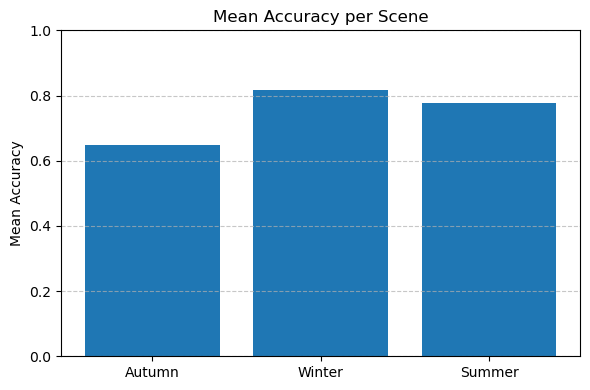

In [10]:
# plot the average accuracies for all three scenes 

# Calculate means for visualization
means = participant_scene_accuracy.groupby('scene')['SceneAccuracy'].mean()

print(means)

# Bar plot of condition means 
plt.figure(figsize=(6, 4))
plt.bar(['Autumn', 'Winter', 'Summer'], means)
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy per Scene')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

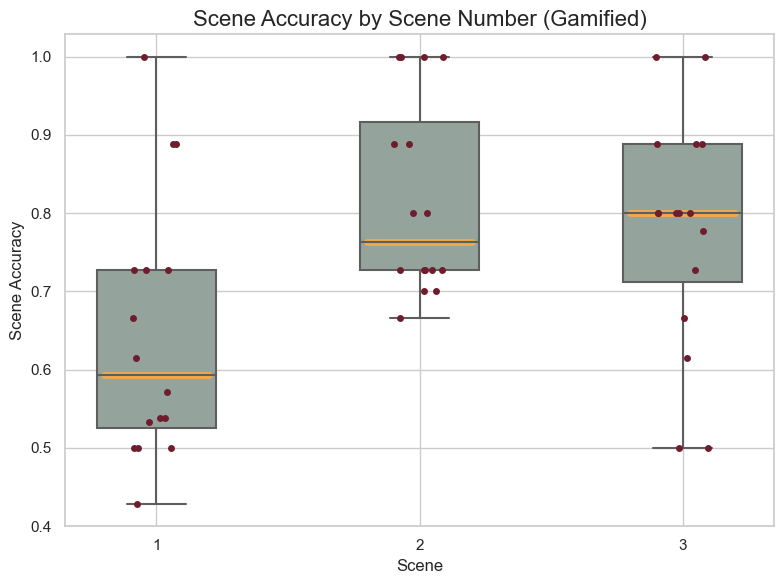

In [11]:
# boxplots for the individual scene accuracies 

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Custom color
box_color = "#91A79C"

# Initialize the plot
plt.figure(figsize=(8, 6))

# Draw boxplot
ax = sns.boxplot(
    x='scene', y='SceneAccuracy', data=participant_scene_accuracy,
    color=box_color,
    width=0.45,
    fliersize=0,
    linewidth=1.5
)

# Overlay datapoints
sns.stripplot(
    x='scene', y='SceneAccuracy', data=participant_scene_accuracy,
    color='#6F1D2D', size=5, jitter=True, alpha=1
)

# Draw thicker median lines manually
median = participant_scene_accuracy.groupby("scene")["SceneAccuracy"].median()
for i, (scene, med_val) in enumerate(median.items()):
    plt.plot([i - 0.2, i + 0.2], [med_val, med_val], color='#F1A84C', lw=5)

# Customize labels and grid
plt.title('Scene Accuracy by Scene Number (Gamified)', fontsize=16)
plt.xlabel('Scene')
plt.ylabel('Scene Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()
